In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [49]:
path='/content/GOOGL_2006-01-01_to_2018-01-01.csv'
df=pd.read_csv(path)

In [50]:
df

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
1,2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2,2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
3,2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
4,2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL
...,...,...,...,...,...,...,...
3014,2017-12-22,1070.00,1071.72,1067.64,1068.86,889446,GOOGL
3015,2017-12-26,1068.64,1068.86,1058.64,1065.85,918767,GOOGL
3016,2017-12-27,1066.60,1068.27,1058.38,1060.20,1116203,GOOGL
3017,2017-12-28,1062.25,1064.84,1053.38,1055.95,994249,GOOGL


In [51]:
df.rename(columns={'open': 'Open', 'close': 'Close','high':'High','low':'Low','volume':'Volume'}, inplace=True)




In [52]:
df



,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
1,2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2,2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
3,2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
4,2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL
...,...,...,...,...,...,...,...
3014,2017-12-22,1070.00,1071.72,1067.64,1068.86,889446,GOOGL
3015,2017-12-26,1068.64,1068.86,1058.64,1065.85,918767,GOOGL
3016,2017-12-27,1066.60,1068.27,1058.38,1060.20,1116203,GOOGL
3017,2017-12-28,1062.25,1064.84,1053.38,1055.95,994249,GOOGL


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
data = df[['Open', 'High', 'Low', 'Close', 'Volume']].values



In [44]:
rsi_period = 14
df['price_change'] = df['Close'].diff()
df['gain'] = np.where(df['price_change'] > 0, df['price_change'], 0)
df['loss'] = np.where(df['price_change'] < 0, -df['price_change'], 0)
avg_gain = df['gain'].rolling(window=rsi_period, min_periods=1).mean()
avg_loss = df['loss'].rolling(window=rsi_period, min_periods=1).mean()
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))
df['rsi'] = rsi
print(df[['Close', 'rsi']])

          Close         rsi
0      13521.12         NaN
1      13529.01  100.000000
2      13560.00  100.000000
3      13203.06    9.822647
4      13225.00   14.558598
...         ...         ...
71306  37684.68   39.081517
71307  37785.78   43.377617
71308  38060.25   54.349253
71309  37881.76   51.391349
71310  37676.00   42.636705

[71311 rows x 2 columns]


In [45]:
sma_window = 20
df['short_sma'] = df['Close'].rolling(window=sma_window, min_periods=1).mean()
sma_window = 45
df['long_sma'] = df['Close'].rolling(window=sma_window, min_periods=1).mean()
af = 0.02
psar = df['Close'].copy()
psar_bull = True

extreme_point = df['Low'].iloc[0]

for i in range(2, len(df)):
    if psar_bull:
        psar[i] = psar[i - 1] + af * (extreme_point - psar[i - 1])
    else:
        psar[i] = psar[i - 1] - af * (psar[i - 1] - extreme_point)
    if psar_bull and df['Low'].iloc[i] < psar[i]:
        psar_bull = False
        psar[i] = extreme_point
        extreme_point = df['High'].iloc[i]
        af = 0.02
    elif not psar_bull and df['High'].iloc[i] > psar[i]:
        psar_bull = True
        psar[i] = extreme_point
        extreme_point = df['Low'].iloc[i]
        af = 0.02
df['psar'] = psar

In [46]:
indicators_df = pd.DataFrame({
    'Close': df['Close'],
    'rsi': df['rsi'],
    'short_sma': df['short_sma'],
    'long_sma': df['long_sma'],
    'psar': df['psar']
})

In [ ]:
buy_condition = (indicators_df['rsi'] < 30) & (indicators_df['close'] > indicators_df['long_sma'])
sell_condition = (indicators_df['rsi'] > 70) & (indicators_df['close'] < indicators_df['long_sma'])

indicators_df['signals'] = 0

indicators_df.loc[buy_condition, 'signals'] = 1
indicators_df.loc[sell_condition, 'signals'] = -1
df['signals']=indicators_df['signals']

In [ ]:
p=(len(df)*3)//4
train_df=df[:p]
features=pd.DataFrame({
    'close': train_df['close'],
    'rsi': train_df['rsi'],
    'short_sma': train_df['short_sma'],
    'long_sma': train_df['long_sma'],
    'psar': train_df['psar']
})
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(features, train_df['signals'])


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#Back Testing


In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [56]:
test_df=df
p=(len(df)*3)//4

test_df=test_df[p:]
time_steps=50
test_df.reset_index(inplace=True)
test_df.drop(columns=['index'],inplace=True)
balance=100000
init=200000
quantity=0
net_worth=100000
history_Close=np.array([test_df.iloc[0]['Close']])
net=np.array([])
bought=0
risk=0.75
max_net_worth=100000
draw=[]
predicted_values=[]
for i in range(1,len(test_df)):
  hist=pd.DataFrame(columns=['Close'])
  hist['Close']=history_Close
  sma_window = 20
  short_sma = hist['Close'].rolling(window=sma_window, min_periods=1).mean()
  sma_window = 40
  long_sma = hist['Close'].rolling(window=sma_window, min_periods=1).mean()
  rsi_period = 14
  hist['price_change'] = hist['Close'].diff()
  hist['gain'] = np.where(hist['price_change'] > 0, hist['price_change'], 0)
  hist['loss'] = np.where(hist['price_change'] < 0, -hist['price_change'], 0)
  avg_gain = hist['gain'].rolling(window=rsi_period, min_periods=1).mean()
  avg_loss = hist['loss'].rolling(window=rsi_period, min_periods=1).mean()
  rs = avg_gain / avg_loss
  rsi = 100 - (100 / (1 + rs))
  hist['rsi'] = rsi
  # print(short_sma.iloc[i],long_sma.iloc[i],rsi.iloc[i])
  Close=test_df.iloc[i]['Close']
  buy_condition = (short_sma.iloc[i-1] > long_sma.iloc[i-1])
  sell_condition = (short_sma.iloc[i-1] < long_sma.iloc[i-1])
  if(buy_condition):
    if(balance>init and bought ==0):
      running=min(balance,init)
      bought=running/Close
      balance=balance-running
    elif(balance and bought==0):
      bought+=balance/Close
      balance=0
  elif(sell_condition):
    if(bought):
      balance+=bought*Close
      bought=0
  net_worth=balance+bought*Close
  print(Close,net_worth,bought,balance)
  net=np.append(net,net_worth)
  history_Close=np.append(history_Close,test_df.iloc[i]['Close'])
  max_net_worth=max(net_worth,max_net_worth)
  draw.append(max(0,((max_net_worth-net_worth)/(max_net_worth))))
  # init=risk*balance
print(net)


<ipython-input-56-21a2bd6f1c4e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=['index'],inplace=True)


519.46 100000.0 0 100000
506.64 100000.0 0 100000
505.15 100000.0 0 100000
506.91 100000.0 0 100000
500.72 100000.0 0 100000
497.06 100000.0 0 100000
501.8 100000.0 0 100000
505.93 100000.0 0 100000
504.01 100000.0 0 100000
510.46 100000.0 0 100000
509.94 100000.0 0 100000
520.39 100000.0 0 100000
537.3 100000.0 0 100000
541.95 100000.0 0 100000
536.72 100000.0 0 100000
521.19 100000.0 0 100000
512.43 100000.0 0 100000
513.23 100000.0 0 100000
537.55 100000.0 0 100000
532.2 100000.0 0 100000
533.3 100000.0 0 100000
526.1 100000.0 0 100000
529.83 100000.0 0 100000
533.88 100000.0 187.30800929047726 0
529.28 99138.3831572638 187.30800929047726 0
540.16 101176.29429834419 187.30800929047726 0
538.0 100771.70899827676 187.30800929047726 0
546.01 102272.04615269348 187.30800929047726 0
551.16 103236.68240053944 187.30800929047726 0
545.01 102084.73814340301 187.30800929047726 0
542.65 101642.69124147749 187.30800929047726 0
546.45 102354.46167678131 187.30800929047726 0
541.8 101483.4794335

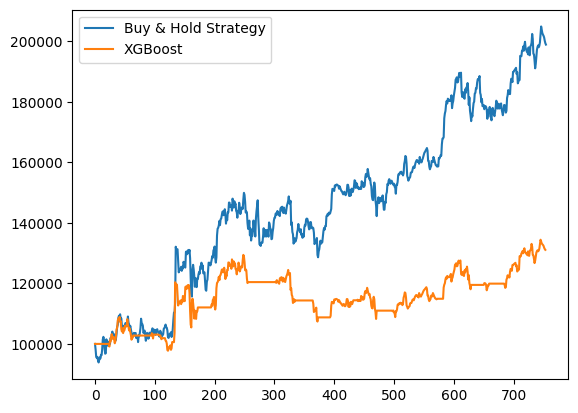

In [57]:
plt.plot(test_df['Close']*(100000/(test_df.iloc[0]['Close'])),label='Buy & Hold Strategy')
plt.plot(net,label='XGBoost')
plt.legend()


Text(0, 0.5, 'Max Drawdown (in %)')

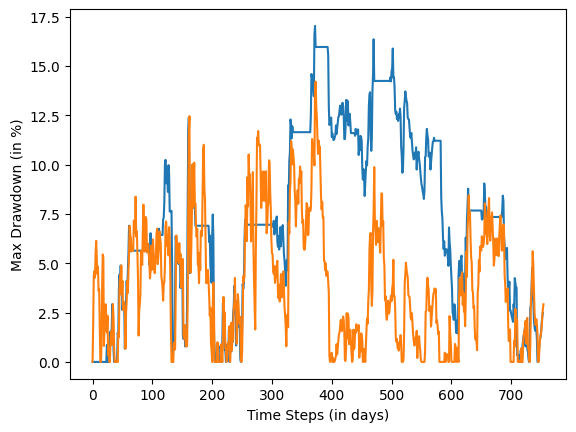

In [58]:
hold_max=100000
hold_draw=[]
for i in range(len(test_df['Close'])):
  curr=(test_df['Close'].iloc[i])*(100000/(test_df.iloc[0]['Close']))
  hold_max=max(hold_max,curr)
  hold_draw.append(max(0,((hold_max-curr)/(hold_max))))
draw=[i*100 for i in draw]
hold_draw=[i*100 for i in hold_draw]
plt.plot(draw,label='Buy & Hold')
plt.plot(hold_draw, label='XGBoost')
plt.xlabel('Time Steps (in days)')
plt.ylabel('Max Drawdown (in %)')


In [ ]:
open=df.iloc[0]['close']
close=df.iloc[len(df)-1]['close']
ret=(close-open)/open
print(ret)


1.7289385123818222


In [ ]:
df


,Date,Open,High,Low,Close,Adj Close,Volume,price_change,gain,loss,rsi,short_sma,long_sma,psar
0,2014-09-17,1999.300049,2010.739990,1993.290039,2001.569946,2001.569946,3209420000,NaN,0.000000,0.000000,NaN,2001.569946,2001.569946,2001.569946
1,2014-09-18,2003.069946,2012.339966,2003.069946,2011.359985,2011.359985,3235340000,9.790039,9.790039,0.000000,100.000000,2006.464966,2006.464966,2011.359985
2,2014-09-19,2012.739990,2019.260010,2006.589966,2010.400024,2010.400024,4880220000,-0.959961,0.000000,0.959961,91.070131,2007.776652,2007.776652,1993.290039
3,2014-09-22,2009.079956,2009.079956,1991.010010,1994.290039,1994.290039,3349670000,-16.109985,0.000000,16.109985,36.448415,2004.404999,2004.404999,2019.260010
4,2014-09-23,1992.780029,1995.410034,1982.770020,1982.770020,1982.770020,3279350000,-11.520020,0.000000,11.520020,25.508176,2000.078003,2000.078003,1991.010010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2333,2023-12-22,4753.919922,4772.939941,4736.770020,4754.629883,4754.629883,3046770000,7.879883,7.879883,0.000000,75.219000,4640.760986,4483.193761,1969.250000
2334,2023-12-26,4758.859863,4784.720215,4758.450195,4774.750000,4774.750000,2513910000,20.120117,20.120117,0.000000,77.026599,4651.976978,4495.429091,1969.250000
2335,2023-12-27,4773.450195,4785.390137,4768.899902,4781.580078,4781.580078,2748450000,6.830078,6.830078,0.000000,81.131399,4663.311475,4507.974425,1969.250000
2336,2023-12-28,4786.439941,4793.299805,4780.979980,4783.350098,4783.350098,2698860000,1.770020,1.770020,0.000000,79.209536,4674.949976,4519.878201,1969.250000
